# Exercices de découverte du PMSI MCO 2 (_Version R_)
Bienvenue sur ce notebook d'introduction à la manipulation des diagnostics hospitaliers dans le PMSI ! L'objectif est de vous accompagner, grâce à une manipulation guidée, dans l’identification simplifiée des diagnostics hospitaliers dans les tables du PMSI MCO (Médecine-Obstétrique-Chirurgie). Des diagnostics hospitaliers sont également identifiables dans les champs HAD (Hospitalisation à domicile), SSR (Soins de suite et réadaptation) et RIM-P (Psychiatrie) du PMSI selon des procédures semblables mais nous ne travaillerons pas sur ces champs.

Vous trouverez le schéma des concepts de fonctionnement du PMSI et l'articulation de ses principales bases sur la [fiche dédiée](https://documentation-snds.health-data-hub.fr/fiches/concepts_PMSI.html#pmsi-mco). Ces quelques exercices sont conçus pour vous accompagner dans la manipulation des données du PMSI et vous familiariser avec leur structure à l'aide de données fictives.

L’ objectif est d’analyser le profil (en termes d’âge et de sexe) des patients avec un diagnostic hospitalier d'écoulement du liquide céphalorachidien (ELCR) dans le PMSI MCO.

**A noter que les données utilisées pour le développement de ce notebook sont des données synthétiques avec les mêmes formats et types des valeurs des données réelles du SNDS. Il s'agit de données fictives générées aléatoirement, qui ne sont pas nécessairement plausibles et ne recouvrent pas une réalité médicale. Ces données ont été générées par le Lab Santé de la DREES.**

Pour plus d'information sur ces données, vous pouvez consulter la [page dédiée sur le site de documentation du SNDS](https://documentation-snds.health-data-hub.fr/ressources/donnees_synthetiques.html#ou-trouver-le-snds-synthetique).

# Préambule : Les diagnostics hospitaliers dans le PMSI
Les diagnostics hospitaliers sont codés selon la 10e version de la classification internationale des maladies [CIM10](https://documentation-snds.health-data-hub.fr/glossaire/cim.html). Un [moteur de recherche pour consulter la CIM10](https://icd.who.int/browse10/2008/fr) se trouve sur le site de l'Organisaton Mondiale de la Santé. Vous pouvez trouver la nomenclature associée `MS_CIM_V` utilisée dans la SNDS sur le [dictionnaire intéractif](https://drees.shinyapps.io/dico-snds/). 

Il existe trois types de diagnostics hospitaliers :
-	Le **diagnostic principal (DP)** :  Problème de santé qui, **a posteriori**, a motivé l’admission du patient dans l’UM. Si plusieurs possibles, c’est celui qui a mobilisé l’essentiel de l’effort de soins.
-	Le **diagnostic relié (DR)** : Facultatif, seulement quand le DP est un code Z (pas une maladie mais un code type « soins palliatifs », « surveillance », « bilan » etc.). Le DR est dans ce cas la maladie qui explique le DP.
-	Le **diagnostic associé (DA)** : Comprend les comorbidités associées au DP. Les DA documentaires (maladies n’ayant pas modifié la prise en charge) ne sont pas renseignés dans le PMSI ; seuls les DA significatifs le sont.

Les diagnostics hospitaliers identifiés dans ces exercices concernent le séjour de manière globale et non le détail des diagnostics établis dans chaque unité médicale (UM). 

En effet, lors d’un séjour hospitalier, le patient peut passer par différentes unités médicales qui établissent chacune leurs DP, DR et DA spécifiques. A la fin du séjour, les informations des différents résumés d’unité médicale (RUM) sont groupées dans un résumé de sortie anonymisé (RSA). Dans le processus de groupage, un DP et un DR parmi l'ensemble des DP et DR des RUM seront retenus pour le RSA. La majorité des autres diagnostics non retenus comme DP ou DR du RSA seront considérés comme DA. Pour avoir une vision exhaustive des diagnostics établis - ce qui ne sera pas le cas dans les exercices - il est conseillé de travailler à partir de la table des RUM (`T_MCOaaUM`).

# Préparation et configuration
Commençons par installer et charger les packages R **dplyr**, **lubridate** et **ggplot** contenant des fonctions dont nous nous servirons dans les exercices.

In [ ]:
# Installation des packages
install.packages("dplyr")
install.packages("lubridate")
install.packages("ggplot2")

In [3]:
# Chargement des packages
library(dplyr)
library(lubridate)
library(ggplot2)


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




Importons maintenant les données synthétiques sur lesquelles nous allons exécuter les exercices.

/!\ Attention, les données synthétiques ne correspondent pas à une période temporelle donnée. Cela est toutefois le cas dans le SNDS où la plupart des tables du PMSI sont annuelles. **Il faut retenir que les bases annuelles du PMSI dans le vrai SNDS ne contiennent que les séjours s’étant terminés pendant l’année.**

In [4]:
# Chemins d'accès aux fichiers
DATA_DIR <- file.path("..", "data")                 # Dossier où sont stockées les données

T_MCO_B_FILE <- file.path(DATA_DIR, "T_MCOaa_nnB.csv")    # MCO - Description du séjour
T_MCO_C_FILE <- file.path(DATA_DIR, "T_MCOaa_nnC.csv")    # MCO - Pseudonymes des patients et dates de soin
T_MCO_D_FILE <- file.path(DATA_DIR, "T_MCOaa_nnD.csv")    # MCO - Diagnostics associés

In [5]:
# Récupération des fichiers de données depuis Gitlab
# Cette étape est optionnelle si les données sont déjà présentes (par exemple si vous avez cloné tout le dossier Gitlab)

GITLAB_DATA_URL <- "https://gitlab.com/healthdatahub/formation/exercices-snds/-/raw/master/data/"

download.file(paste(GITLAB_DATA_URL, "T_MCOaa_nnB.csv", sep = ""), T_MCO_B_FILE)
download.file(paste(GITLAB_DATA_URL, "T_MCOaa_nnC.csv", sep = ""), T_MCO_C_FILE)
download.file(paste(GITLAB_DATA_URL, "T_MCOaa_nnD.csv", sep = ""), T_MCO_D_FILE)

In [6]:
# Import des données
T_MCOaa_nnB <- read.csv(T_MCO_B_FILE)           # Description séjour
T_MCOaa_nnC <- read.csv(T_MCO_C_FILE)           # NIR patient et dates 
T_MCOaa_nnD <- read.csv(T_MCO_D_FILE)           # Diagnostics associés

On prépare les vecteurs dont nous aurons besoin :

-	**Les doublons d'établissements de soins à supprimer** : Dans le SNDS, des nettoyages sont nécessaires pour la bonne exploitation des données. Au niveau du PMSI, l'un d'entre eux consiste à supprimer les doublons au niveau de certains établissements de soins grâce à leur numéro FINESS. En effet, pour l’APHP (Assistance Publique - Hôpitaux de Paris), les HCL (Hospices Civils de Lyon) et l’APHM (Hôpitaux Universitaires de Marseille), les établissements sont présents à la fois sous leur code FINESS géographique et juridique (jusqu’en 2018). Afin de ne pas les compter en double, il faut supprimer un certain nombre de codes grâce à la variable `ETA_NUM` renseignant le code FINESS des établissements. Vous trouverez ci-dessous un vecteur *eta_num_supr* avec les codes ETA_NUM à supprimer lorsqu'on travaille sur le PMSI (cf. [Fiche Dépenses des établissements de santé publics dans le PMSI](https://documentation-snds.health-data-hub.fr/fiches/depenses_hopital_public.html#valorisation-des-sejours-a-l-hopital-public)).

In [7]:
# ETA_NUM doubles à supprimer
eta_num_supr<-c('130780521','130783236', '130783293', '130784234', '130804297', '600100101','750041543', '750100018',
                '750100042', '750100075', '750100083', '750100091', '750100109', '750100125','750100166', '750100208', 
                '750100216', '750100232', '750100273', '750100299', '750801441', '750803447','750803454', '910100015', 
                '910100023', '920100013', '920100021', '920100039', '920100047', '920100054','920100062', '930100011', 
                '930100037', '930100045', '940100027', '940100035', '940100043', '940100050','940100068', '950100016', 
                '690783154', '690784137', '690784152', '690784178', '690787478', '830100558')

- **Les codes CIM10 pour identifier la pathologie recherchée**, ici l’écoulement céphalorachidien (ELCR) :
    - G96 : Ecoulement du liquide céphalorachidien
    - G970 : Ecoulement du liquide céphalorachidien après rachicentèse

In [8]:
# Code diagnostics CIM10 recherchés
diag_cim10 <- c("G96", "G970")

# Exercice 1 : Récupération des séjours avec des diagnostics comportant les codes CIM10 recherchés (ELCR)
Le DP et DR du séjour hospitalier sont respectivement stockés dans les variables `DGN_PAL` et `DGN_REL` et se trouvent dans la table des séjours `T_MCOaaB`. Le séjour possède toujours un unique DP ; le DR est optionnel et est unique aussi pour le séjour.
Un séjour hospitalier est identifié par le couple `ETA_NUM` (numéro FINESS de l’établissement de soins) et `RSA_NUM` (numéro du résumé de sortie anonymisé). Ces deux variables servent de clés de jointure au sein du PMSI MCO. La table `T_MCOaaB` contient également les caractéristiques démographiques du patient (âge : `AGE_ANN`, sexe : `COD_SEX`) mais pas le pseudonyme patient, ni les dates de séjour.

In [9]:
# Récupération des diagnostics principaux et reliés dans T_MCOaaB
diag_princ_rel <- T_MCOaa_nnB %>%
  select(ETA_NUM, RSA_NUM, GRG_GHM, SEJ_NBJ, DGN_PAL, DGN_REL, AGE_ANN, COD_SEX) %>%
  filter(substr(DGN_PAL,1,3) %in% c("G96") | substr(DGN_REL,1,3) %in% c("G96") |
           substr(DGN_PAL,1,4) %in% c("G970") | substr(DGN_REL,1,4) %in% c("G970"),
         !ETA_NUM %in% eta_num_supr, substr(GRG_GHM,1,2) != '90') # suppression des séjours en erreur et les établissement en doublons

head(diag_princ_rel)

ETA_NUM   RSA_NUM    GRG_GHM SEJ_NBJ DGN_PAL DGN_REL AGE_ANN COD_SEX
1 514568961 4797034198 JOwHbb  2556    G970    F2011    40     1      
2 545311862 9954230169 nMJPyP  2635    F319    G970     14     7      
3 751735449 7852887004 vsstTg   463    G969    F428     19     1      
4 574597472 7923868566 pgJelh  2841    G969    F318    117     2      
5 879549206 7688485884 hIkabI  1495    G970    F2041     8     1      
6 602191672 5648433194 WCYobW   133    F4480   G969      9     7

Les DA du séjour hospitalier sont stockés dans la variable `ASS_DGN` qui se trouve dans la table `T_MCOaaD`. Contrairement au DP et DR, un séjour peut posséder plusieurs DA. Pour information, Le nombre de DA renseignés pour un séjour donné (couple `ETA_NUM`, `RSA_NUM`) est stocké dans la variable `DGN_ASS_NUM` dans la même table. 

In [10]:
# Récupération des diagnostics associés dans T_MCOaaD (plusieurs DA par séjour/patient possible)
diag_ass <- T_MCOaa_nnD %>%
  filter(substr(ASS_DGN,1,3) %in% c("G96") | substr(ASS_DGN,1,4) %in% c("G970"))

head(diag_ass)

ASS_DGN DGN_ASS_NUM ETA_NUM   RSA_NUM    RSS_NUM
1 G969    7404        392381480 1520653005        
2 G969    8727        863007477 1716226784        
3 G970     481        513072894 2479454372 Z      
4 G970    3484        548324595 2195896160 T      
5 G970      54        580144897 7531156073 B      
6 G970    1051        863007477 6525685393 tt

Pour récupérer les caractéristiques démographiques du patient, il faut réaliser une jointure entre l’extraction de la table `T_MCOaaD` et la table `T_MCOaaB` grâce aux clés de jointure du PMSI MCO : `ETA_NUM` et `RSA_NUM`.
Par ailleurs, il est d'usage de supprimer les séjours dits « en erreur » (deux premiers caractères de `GRG_GHM` différents de '90').
Ces séjours sont : 
- soit des séjours qui contiennent des informations manquantes (diagnostics, âge, date de sortie, etc.) qui ne permettent pas de grouper le séjour (algorithme de groupage) et de lui attribuer un tarif
- soit ce sont de « faux » séjours générés automatiquement pour des besoins de facturation (dialyse, activité externe, etc...) des établissements privés.

In [11]:
# On ne garde que les DA des séjours qui ne sont pas codés en erreur + récupération de l'âge et du sexe des patients avec un DA
# à partir de la table T_MCOaaB
diag_ass2 <- left_join(diag_ass, T_MCOaa_nnB %>%
                         select(ETA_NUM, RSA_NUM, GRG_GHM, SEJ_NBJ, DGN_PAL, DGN_REL, AGE_ANN, COD_SEX) %>%
                         filter(!ETA_NUM %in% eta_num_supr, substr(GRG_GHM,1,2) != '90'),
                       by=c("ETA_NUM", "RSA_NUM"))

On compile ensuite les données :

In [12]:
# Regroupement des DP, DR, DA de ELCR
diag_princ_rel_ass <- bind_rows(diag_princ_rel,diag_ass2)

head(diag_princ_rel_ass)

ETA_NUM   RSA_NUM    GRG_GHM SEJ_NBJ DGN_PAL DGN_REL AGE_ANN COD_SEX ASS_DGN
1 514568961 4797034198 JOwHbb  2556    G970    F2011    40     1       NA     
2 545311862 9954230169 nMJPyP  2635    F319    G970     14     7       NA     
3 751735449 7852887004 vsstTg   463    G969    F428     19     1       NA     
4 574597472 7923868566 pgJelh  2841    G969    F318    117     2       NA     
5 879549206 7688485884 hIkabI  1495    G970    F2041     8     1       NA     
6 602191672 5648433194 WCYobW   133    F4480   G969      9     7       NA     
  DGN_ASS_NUM RSS_NUM
1 NA          NA     
2 NA          NA     
3 NA          NA     
4 NA          NA     
5 NA          NA     
6 NA          NA

# Exercice 2 : Récupérer le pseudonyme patient et les dates de séjour associés au séjour avec un diagnostic de ELCR

Nous venons de récupérer les diagnostics hospitaliers des séjours dans les tables `T_MCOaaB` et `T_MCOaaD`. Toutefois, ces tables ne contiennent pas l’information sur le pseudonyme patient, ni sur les dates de séjour. Ces informations sont à récupérer dans la table `T_MCOaaC` en utilisant les clés de jointure du PMSI MCO : `ETA_NUM` et `RSA_NUM`.

Le pseudonyme patient est stocké dans la variable `NIR_ANO_17`. Pour information, cette variable s’appelle `BEN_NIR_PSA` dans les tables du DCIR.

La date de début et de fin de séjour sont respectivement stockées dans les variables `EXE_SOI_DTD` et `EXE_SOI_DTF`.

NB : Les données utilisées dans ce notebook étant générées aléatoirement, il est possible qu'il y ait des incohérences dans les données. Ainsi, dans ces données, on peut trouver un séjour (`ETA_NUM` + `RSA_NUM`) associé à plusieurs personnes (`NIR_ANO_17`) alors que cela n’est pas possible dans le vrai SNDS. Une opération de mise en cohérence des données `T_MCOaaC` est donc nécessaire ici mais cette action n'est pas à faire lorsqu'on travaille sur un jeu de données réelles.

In [13]:
# Mise en cohérence de la table T_MCOaaC
T_MCOaa_nnC2 <- T_MCOaa_nnC %>%
  group_by(ETA_NUM, RSA_NUM) %>%
  filter(row_number() == 1)

On réalise une jointure avec la table `T_MCOaaC` mise en cohérence grâce aux clés de jointure `ETA_NUM` et `RSA_NUM` pour récupérer le pseudonyme patient et les dates de séjour.

In [14]:
# Fusion avec la table T_MCOaaC pour récupérer le pseudonyme et les dates du séjour
patient_diag_ecr <- inner_join(diag_princ_rel_ass, T_MCOaa_nnC2[,c("ETA_NUM","RSA_NUM", "NIR_ANO_17", "EXE_SOI_DTD","EXE_SOI_DTF")],
                              by=c("ETA_NUM","RSA_NUM"))

Dans l’éventualité où une personne peut avoir été hospitalisée plusieurs fois avec un diagnostic d’ELCR, il faut penser à ne garder qu'un seul évènement par patient. Ici, dans le cas de doublons de `NIR_ANO_17`, on garde les informations associées à la date de séjour (date d’entrée : `EXE_SOI_DTD`) la plus ancienne.

In [15]:
# On garde, pour chaque patient avec un diagnostic d'ELCR, les informations récoltées lors de la date d'hopsitalisation la plus ancienne
patient_prem_diag <- patient_diag_ecr %>%
  mutate(diag_date=as.Date(substr(EXE_SOI_DTF,1,9), "%d%b%Y")) %>%
  group_by(NIR_ANO_17) %>% 
slice(which.min(as.Date(substr(as.character(EXE_SOI_DTF),1,9), "%d%b%Y")))

head(patient_prem_diag)  

ETA_NUM   RSA_NUM    GRG_GHM SEJ_NBJ DGN_PAL DGN_REL AGE_ANN COD_SEX ASS_DGN
1 319598408 2143982027 uCJBPx   726    F3151   F2028   55      8       G970   
2 236471725 4122323644 JYmtxP  1927    F1972   F512    26      8       G969   
3 378917557 6804151999 ZkuvQr   945    F315    F2054   77      7       G970   
4 513072894 2479454372 CzUkPb  1891    F340    F45     74      9       G970   
5 815908077 4324268246 nhOFKG  2554    F315    F3311   43      2       G970   
6 548324595 2195896160 yhuarK   827    F318    F428    52      8       G970   
  DGN_ASS_NUM RSS_NUM NIR_ANO_17        EXE_SOI_DTD        EXE_SOI_DTF       
1 8892        Da      aEvKsECmoJoSUeuCi 24Oct1902:16:23:17 27May1965:08:34:54
2 9507                aWbCEJJLUEhCOEFow 20Jun1984:11:06:22 02May1999:11:46:00
3 9199        Zef     CzJZPUuvpcjRBsifl 28Jul1948:08:34:29 10Jul2011:22:02:39
4  481        Z       EZYHWLIARxwkPaoaj 09May2010:16:28:00 12May1934:15:23:11
5 7180                fnBFVsUtuxIuOTXKu 07Aug1966:12:01:48 11Jun1962:19:08:14
6 3484        T       fTCbVTYoMOMSsZGHG 25Dec1966:14:09:10 06Nov1964:19:24:30
  diag_date 
1 1965-05-27
2 1999-05-02
3 2011-07-10
4 1934-05-12
5 1962-06-11
6 1964-11-06

# Exercice 3 : Statistiques descriptives et graphique

On crée les classes d'âge et on change le codage du sexe :

In [16]:
# Classes d'âge
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN<18]<-"[0-17]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=18 & patient_prem_diag$AGE_ANN<=24]<-"[18-24]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=25 & patient_prem_diag$AGE_ANN<=29]<-"[25-29]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=30 & patient_prem_diag$AGE_ANN<=39]<-"[30-39]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=40 & patient_prem_diag$AGE_ANN<=49]<-"[40-49]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=50 & patient_prem_diag$AGE_ANN<=59]<-"[50-59]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=60 & patient_prem_diag$AGE_ANN<=69]<-"[60-69]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=70 & patient_prem_diag$AGE_ANN<=79]<-"[70-79]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=80 & patient_prem_diag$AGE_ANN<=89]<-"[80-89]"
patient_prem_diag$AGE_CAT[patient_prem_diag$AGE_ANN>=90]<-"[90+]"

Warning message:
"Unknown or uninitialised column: `AGE_CAT`."


In [17]:
# Recodage du sexe
patient_prem_diag$COD_SEX<-factor(patient_prem_diag$COD_SEX,
                                  levels=c("1","2","0","7","8","9"),
                                  labels=c("Hommes", "Femmes", "Inconnu","Inconnu","Inconnu", "Inconnu"))

Tableau de fréquence par sexe des patients :

In [18]:
# Tableau de fréquence en nombre d'observations
print("Tableau de fréquence par sexe en nombre d'observations :")
table(patient_prem_diag$COD_SEX)

# Tableau de fréquence en pourcentage d'observations
print("Tableau de fréquence par sexe en pourcentage d'observations :")
round(prop.table(table(patient_prem_diag$COD_SEX))*100,1)

[1] "Tableau de fréquence par sexe en nombre d'observations :"



 Hommes  Femmes Inconnu 
      4       7      25 

[1] "Tableau de fréquence par sexe en pourcentage d'observations :"



 Hommes  Femmes Inconnu 
   11.1    19.4    69.4 

On calcule les distributions d’âge suivant les différentes strates de sexe :

In [19]:
# Distribution âge ensemble
print("Distribution âge de l'ensemble des patients :")
print(quantile(patient_prem_diag$AGE_ANN))
paste("L'âge moyen est de :", round(mean(patient_prem_diag$AGE_ANN)), "ans")

# Distribution âge hommes
print("Distribution âge des patients hommes :")
print(quantile(patient_prem_diag$AGE_ANN[patient_prem_diag$COD_SEX=="Hommes"]))
paste("L'âge moyen est de :", round(mean(patient_prem_diag$AGE_ANN[patient_prem_diag$COD_SEX=="Hommes"])), "ans")

# Distribution âge femmes
print("Distribution âge des patients femmes :")
print(quantile(patient_prem_diag$AGE_ANN[patient_prem_diag$COD_SEX=="Femmes"]))
paste("L'âge moyen est de :", round(mean(patient_prem_diag$AGE_ANN[patient_prem_diag$COD_SEX=="Femmes"])), "ans")

# Distribution âge sexe inconnu
print("Distribution âge des patients avec sexe inconnu :")
print(quantile(patient_prem_diag$AGE_ANN[patient_prem_diag$COD_SEX=="Inconnu"]))
paste("L'âge moyen est de :", round(mean(patient_prem_diag$AGE_ANN[patient_prem_diag$COD_SEX=="Inconnu"])), "ans")

# Distribution des catégories d'âge
print("Tableau de fréquence par âge catégorisé en nombre d'observations :")
table(patient_prem_diag$AGE_CAT)

print("Tableau de fréquence par âge catégorisé en pourcentage d'observations :")
round(prop.table(table(patient_prem_diag$AGE_CAT))*100,1)

[1] "Distribution âge de l'ensemble des patients :"
   0%   25%   50%   75%  100% 
  8.0  28.5  53.5  80.5 107.0 


[1] "L'âge moyen est de : 56 ans"

[1] "Distribution âge des patients hommes :"
    0%    25%    50%    75%   100% 
 14.00  17.75  58.00  99.50 107.00 


[1] "L'âge moyen est de : 59 ans"

[1] "Distribution âge des patients femmes :"
   0%   25%   50%   75%  100% 
 23.0  49.0  70.0 101.5 106.0 


[1] "L'âge moyen est de : 71 ans"

[1] "Distribution âge des patients avec sexe inconnu :"
  0%  25%  50%  75% 100% 
   8   29   47   74  103 


[1] "L'âge moyen est de : 52 ans"

[1] "Tableau de fréquence par âge catégorisé en nombre d'observations :"



 [0-17] [18-24] [25-29] [30-39] [40-49] [50-59] [70-79] [80-89]   [90+] 
      5       2       3       1       6       5       5       1       8 

[1] "Tableau de fréquence par âge catégorisé en pourcentage d'observations :"



 [0-17] [18-24] [25-29] [30-39] [40-49] [50-59] [70-79] [80-89]   [90+] 
   13.9     5.6     8.3     2.8    16.7    13.9    13.9     2.8    22.2 

On représente les distributions par âge et sexe sous forme de graphique (histogramme) :

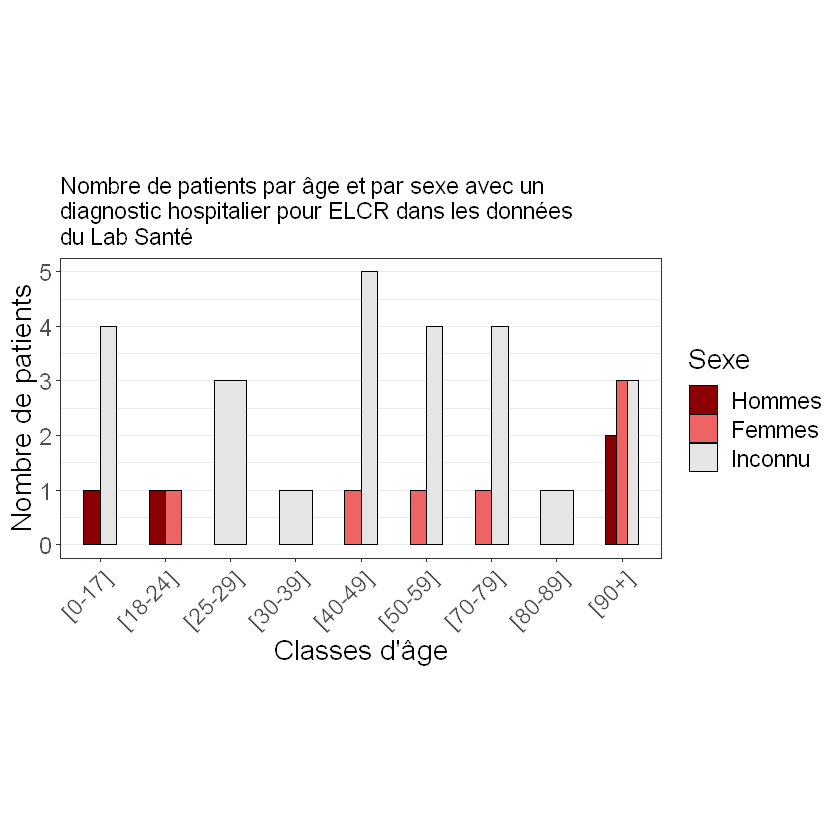

In [20]:
# Graphique
graph<-ggplot(data = patient_prem_diag) + 
  geom_bar(aes(x = AGE_CAT, fill=COD_SEX), stat="count", col="black", lwd=0.1, position="dodge", width=0.5) +
  theme_bw() + ylab("Nombre de patients") + xlab("Classes d'âge") + labs(fill="Sexe") +
  scale_fill_manual(values=c("red4", "indianred2","gray90")) +
  ggtitle("Nombre de patients par âge et par sexe avec un \ndiagnostic hospitalier pour ELCR dans les données \ndu Lab Santé") +
  theme(text = element_text(size=17), panel.grid.major.x = element_blank(), 
  plot.title = element_text(size = 14), aspect.ratio=0.5, axis.text.x=element_text(angle = 45, hjust=1))

graph